In [1]:
include("utils.jl")
include("dataset.jl")
include("vae.jl")
using .Utils
using .Dataset
using .VAE

using Flux
using LightGraphs
import BSON
using ArgParse
using Profile
import JLD
using NPZ
using PyCall
using Printf
using MLBase

┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/LightGraphs/Xm08G.ji for LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/ArgParse/apuSZ.ji for ArgParse [c7e460c6-2fb9-53a9-8c5b-16f535851c63]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/JLD/l8ijy.ji for JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/NPZ/TV7Kn.ji for NPZ [15e1cf62-19b3-5cfa-8e77-841668bca605]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.1/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184


In [2]:
cd("..")

In [3]:
"""Load the adjacency matrix and features."""
function dataset(args)
    adjfeatures = npzread(args["dataset"])

    features = transpose(adjfeatures["features"])

    # Make sure we have a non-weighted graph
    @assert Set(adjfeatures["adjdata"]) == Set([1])

    # Remove any diagonal elements in the matrix
    rows = adjfeatures["adjrow"]
    cols = adjfeatures["adjcol"]
    nondiagindices = findall(rows .!= cols)
    rows = rows[nondiagindices]
    cols = cols[nondiagindices]
    # Make sure indices start at 0
    @assert minimum(rows) == minimum(cols) == 0

    # Construct the graph
    edges = LightGraphs.SimpleEdge.(1 .+ rows, 1 .+ cols)
    g = SimpleGraphFromIterator(edges)

    # Check sizes for sanity
    @assert size(g, 1) == size(g, 2) == size(features, 2)
    g, convert(Array{Float32}, features), convert(Array{Float32}, scale_center(features))
end


"""Define the function compting AUC and AP scores for model predictions (adjacency only)"""
function make_perf_scorer(;enc, sampleξ, dec, greal::SimpleGraph, test_true_edges, test_false_edges)
    # Convert test edge arrays to indices
    test_true_indices = CartesianIndex.(test_true_edges[:, 1], test_true_edges[:, 2])
    test_false_indices = CartesianIndex.(test_false_edges[:, 1], test_false_edges[:, 2])

    # Prepare ground truth values for test edges
    Areal = Array(adjacency_matrix(greal))
    real_true = Areal[test_true_indices]
    @assert real_true == ones(length(test_true_indices))
    real_false = Areal[test_false_indices]
    @assert real_false == zeros(length(test_false_indices))
    real_all = vcat(real_true, real_false)

    metrics = pyimport("sklearn.metrics")

    function perf(x)
        μ = enc(x)[1]
        Alogitpred = dec(μ)[1].data
        pred_true = Utils.threadedσ(Alogitpred[test_true_indices])
        pred_false = Utils.threadedσ(Alogitpred[test_false_indices])
        pred_all = vcat(pred_true, pred_false)

        metrics[:roc_auc_score](real_all, pred_all), metrics[:average_precision_score](real_all, pred_all)
    end

    perf
end

make_perf_scorer

In [4]:
dargs = Dict(
    "dataset" => "datasets/gae-benchmarks/cora.npz",
    "blurring" => 0.15,
    "feature-distribution" => VAE.Bernoulli,
    "diml1" => 32,
    "dimxiadj" => 16,
    "dimxifeat" => 16,
    "overlap" => 0,
    "bias" => false,
    "sharedl1" => false,
    "decadjdeep" => true,
    "nepochs" => 200,
    "savehistory" => nothing,
    "saveweights" => nothing,
    "initb" => VAE.Layers.nobias,
)
sargs = copy(dargs)
sargs["decadjdeep"] = false

false

In [5]:
g, labels, features = dataset(dargs)

({2708, 5278} undirected simple Int64 graph, Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[-0.00210012 -0.00337389 … -0.00262392 -0.00252758; -0.00210012 -0.00337389 … -0.00262392 -0.00252758; … ; -0.00210012 -0.00337389 … -0.00262392 -0.00252758; -0.00210012 -0.00337389 … -0.00262392 -0.00252758])

In [6]:
BSON.@load "tmp/deep-dataset.bson" gtrain test_true_edges test_false_edges
dgtrain, dtest_true_edges, dtest_false_edges, = gtrain, test_true_edges, test_false_edges
BSON.@load "tmp/shallow-dataset.bson" gtrain test_true_edges test_false_edges
sgtrain, stest_true_edges, stest_false_edges, = gtrain, test_true_edges, test_false_edges

@assert collect(edges(dgtrain)) == collect(edges(sgtrain))
@assert dtest_true_edges == stest_true_edges
@assert dtest_false_edges == stest_false_edges

In [7]:
feature_size = size(features, 1)

denc, dsampleξ, ddec, dparamsenc, dparamsdec = VAE.make_vae(
    g = gtrain, feature_size = feature_size, args = dargs)
dparamsvae = Flux.params()
push!(dparamsvae, dparamsenc..., dparamsdec...)
senc, ssampleξ, sdec, sparamsenc, sparamsdec = VAE.make_vae(
    g = gtrain, feature_size = feature_size, args = sargs)
sparamsvae = Flux.params()
push!(sparamsvae, sparamsenc..., sparamsdec...);

Info: using unshared l1 encoder
Info: using deep adjacency decoder
Info: using boolean feature decoder
Info: using unshared l1 encoder
Info: using shallow adjacency decoder
Info: using boolean feature decoder


In [8]:
using Distributions

BSON.@load "tmp/deep-weights.bson-0" weights
dweights0 = weights
BSON.@load "tmp/shallow-weights.bson-0" weights
sweights0 = weights

BSON.@load "tmp/deep-weights.bson" weights
dweights200 = weights
BSON.@load "tmp/shallow-weights.bson" weights
sweights200 = weights;

In [9]:
dlosses, dloss = VAE.make_losses(
    g = gtrain, labels = labels, feature_size = feature_size, args = dargs,
    enc = denc, sampleξ = dsampleξ, dec = ddec,
    paramsenc = dparamsenc, paramsdec = dparamsdec)
slosses, sloss = VAE.make_losses(
    g = gtrain, labels = labels, feature_size = feature_size, args = sargs,
    enc = senc, sampleξ = ssampleξ, dec = sdec,
    paramsenc = sparamsenc, paramsdec = sparamsdec)

dperf = make_perf_scorer(
    enc = denc, sampleξ = dsampleξ, dec = ddec,
    greal = g, test_true_edges = dtest_true_edges, test_false_edges = dtest_false_edges)
sperf = make_perf_scorer(
    enc = senc, sampleξ = ssampleξ, dec = sdec,
    greal = g, test_true_edges = stest_true_edges, test_false_edges = stest_false_edges);

In [10]:
dlosses(features)

Dict{String,Flux.Tracker.TrackedReal{Float32}} with 4 entries:
  "adj"  => 1.63683 (tracked)
  "feat" => 1.00339 (tracked)
  "kl"   => 4.6381e-7 (tracked)
  "reg"  => 0.00136437 (tracked)

In [11]:
slosses(features)

Dict{String,Flux.Tracker.TrackedReal{Float32}} with 4 entries:
  "adj"  => 2.48287 (tracked)
  "feat" => 1.00212 (tracked)
  "kl"   => 4.023e-7 (tracked)
  "reg"  => 0.000831678 (tracked)

In [12]:
dperf(features)

(0.5648355397408428, 0.5884683368767226)

In [13]:
sperf(features)

(0.738587739771452, 0.7426275208914365)

In [14]:
using Makie

adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, sampleξ, dec, x, refx, g, dims, mincolor = 0.0)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(x)
    logitÂ, unormF̂ = dec(sampleξ(embμ, emblogσ))
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (mincolor, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., markersize = markersize(embμ)), #, color = colorsrgb
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
    )
end

function plotweights(weights...)
    theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
    vbox([hbox(heatmap(w), text(theme, repr(size(w)))) for w in weights]...)
end

plotweights (generic function with 1 method)

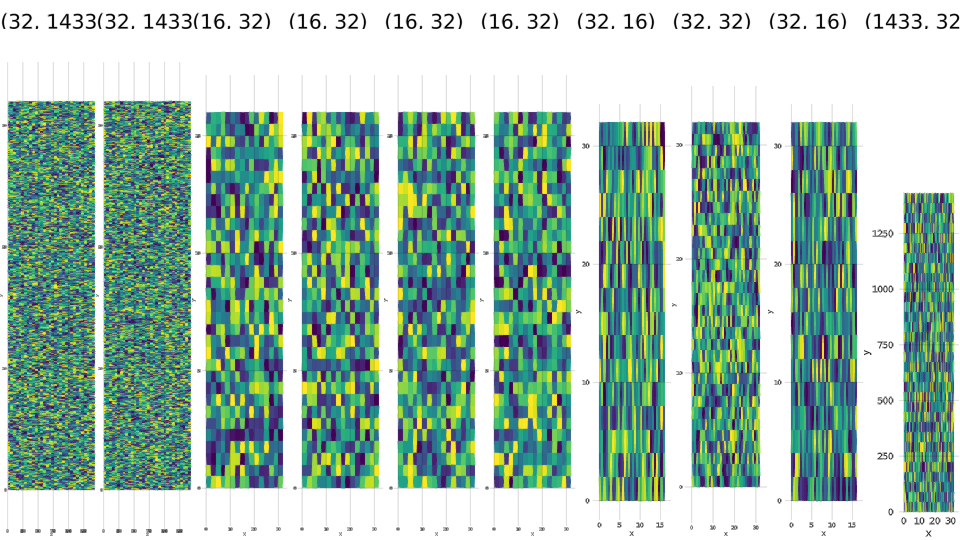

In [15]:
plotweights(dweights0...)

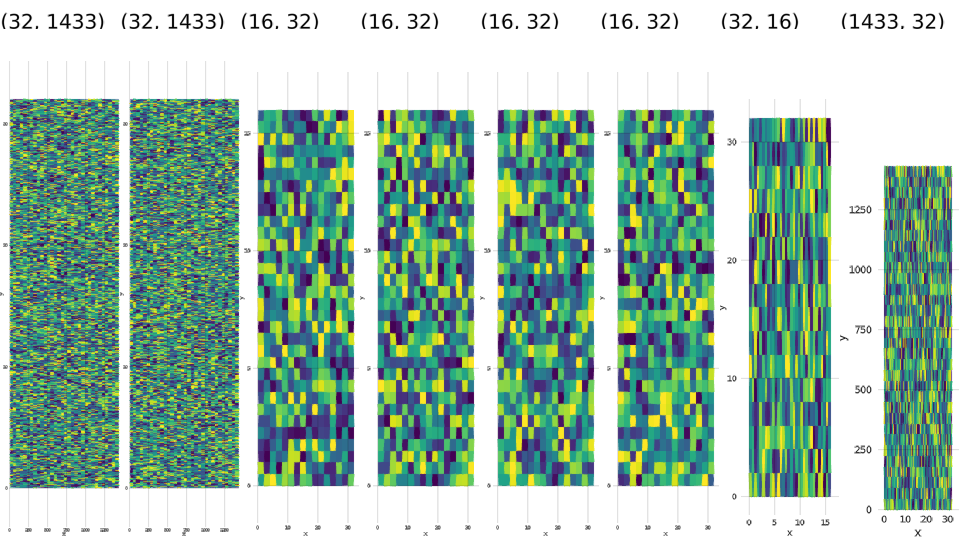

In [16]:
plotweights(sweights0...)

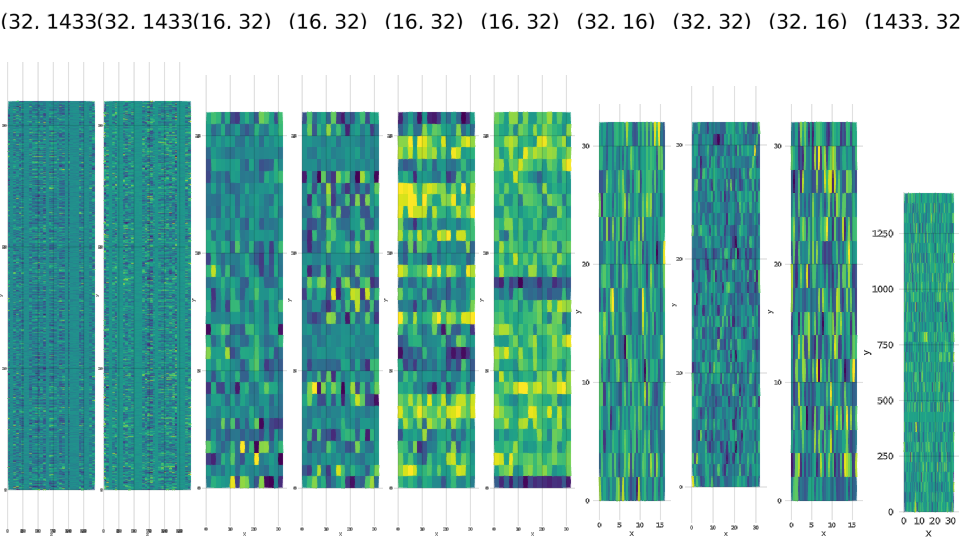

In [17]:
plotweights(dweights200...)

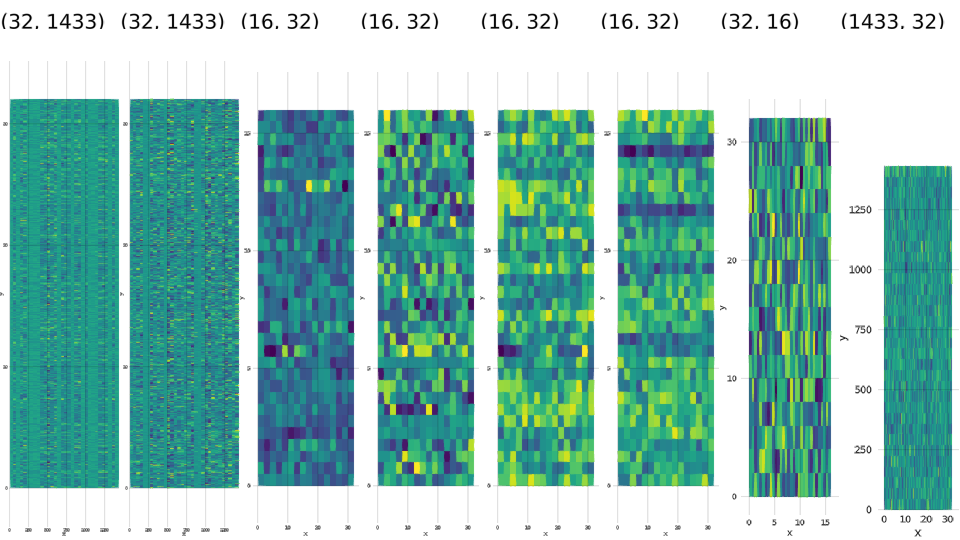

In [18]:
plotweights(sweights200...)

### Epoch 0

In [19]:
Utils.loadparams!(dparamsvae, dweights0)
Utils.loadparams!(sparamsvae, sweights0)

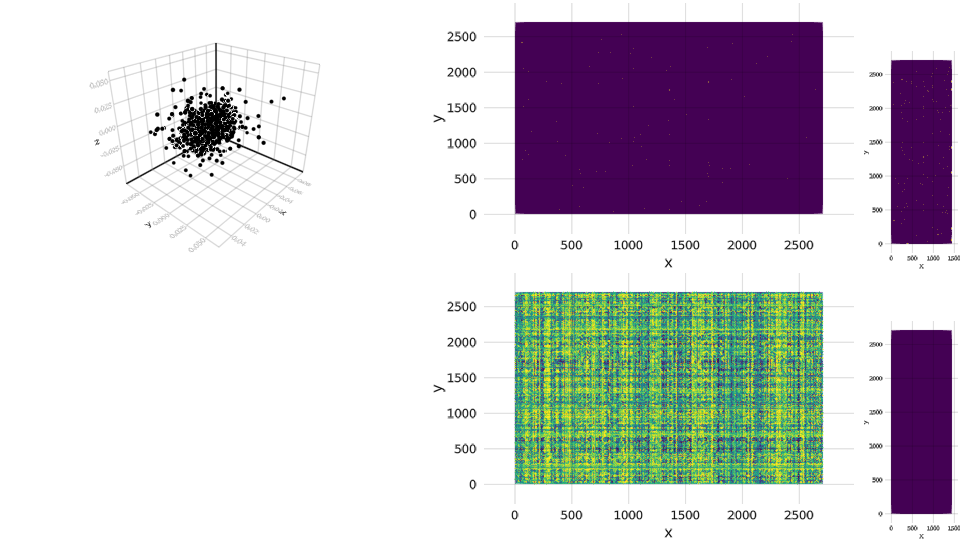

In [20]:
plotstate(enc = denc, sampleξ = dsampleξ, dec = ddec, x = features, refx = labels, g = gtrain, dims = 1:3)

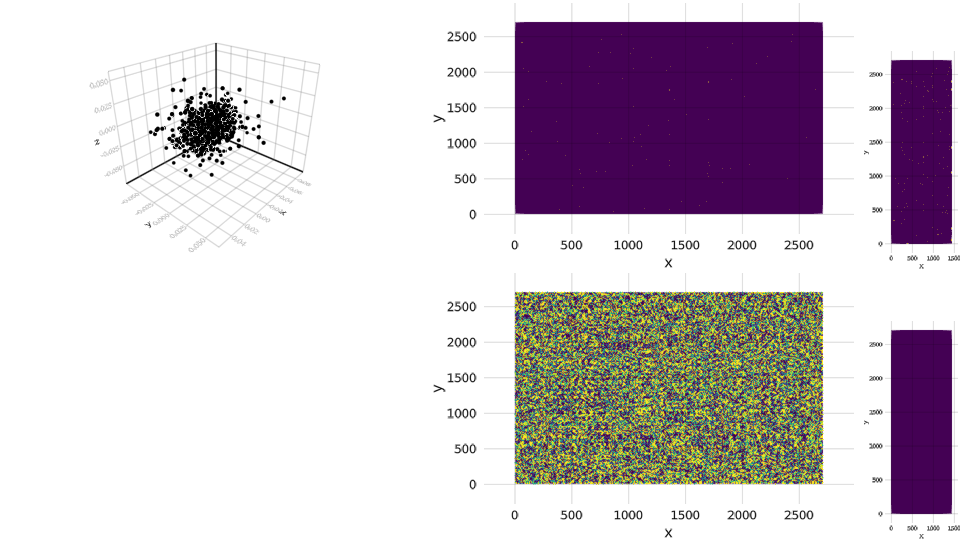

In [21]:
plotstate(enc = senc, sampleξ = ssampleξ, dec = sdec, x = features, refx = labels, g = gtrain, dims = 1:3)

### Epoch 200

In [22]:
Utils.loadparams!(dparamsvae, dweights200)
Utils.loadparams!(sparamsvae, sweights200)

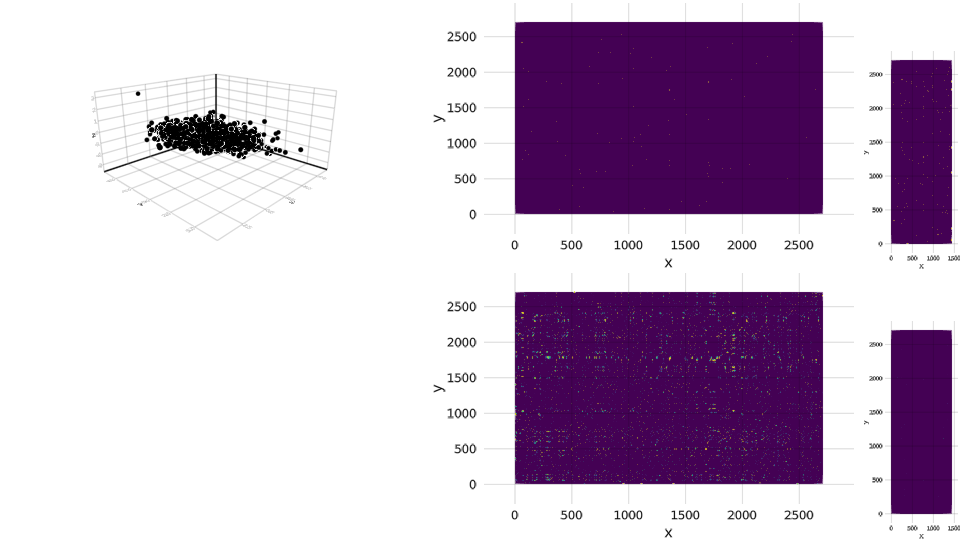

In [23]:
plotstate(enc = denc, sampleξ = dsampleξ, dec = ddec, x = features, refx = labels, g = gtrain, dims = 1:3)

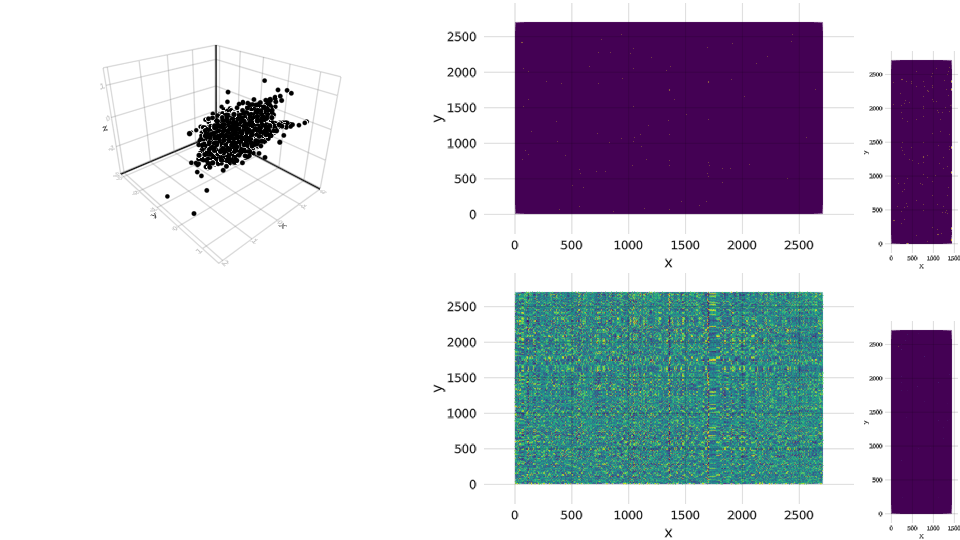

In [24]:
plotstate(enc = senc, sampleξ = ssampleξ, dec = sdec, x = features, refx = labels, g = gtrain, dims = 1:3)#, mincolor = 0.7)

In [25]:
function plot_perf(;enc, dec, x, greal::SimpleGraph, test_true_edges, test_false_edges)
    # Convert test edge arrays to indices
    test_true_indices = CartesianIndex.(test_true_edges[:, 1], test_true_edges[:, 2])
    test_false_indices = CartesianIndex.(test_false_edges[:, 1], test_false_edges[:, 2])

    # Prepare ground truth values for test edges
    Areal = Array(adjacency_matrix(greal))
    real_true = Areal[test_true_indices]
    @assert real_true == ones(length(test_true_indices))
    real_false = Areal[test_false_indices]
    @assert real_false == zeros(length(test_false_indices))
    real_all = vcat(real_true, real_false)

    μ = enc(x)[1]
    Alogitpred = dec(μ)[1].data
    pred_true = Utils.threadedσ(Alogitpred[test_true_indices])
    pred_false = Utils.threadedσ(Alogitpred[test_false_indices])
    pred_all = vcat(pred_true, pred_false)
    n = length(real_all)
    
    scenescatter = Scene()
    scenepr = Scene()
    sceneauc = Scene()
    
    ypos = lift(scenescatter.events.mouseposition) do mpos
        min(1, max(0, to_world(scenescatter, Point2f0(mpos))[2]))
    end
    ystr = lift(p -> @sprintf("Threshold = %.2f", p), ypos)
    colors = lift(ypos) do thres
        map(v -> v ? :green : :red, (pred_all .>= thres) .== real_all)
    end
    yline = lift(ypos) do thres
        repeat([thres], n)
    end
    ypr = lift(ypos) do thres
        r = roc(real_all, pred_all, thres)
        [Point2f0(recall(r), precision(r))]
    end
    yauc = lift(ypos) do thres
        r = roc(real_all, pred_all, thres)
        [Point2f0(false_positive_rate(r), true_positive_rate(r))]
    end
    
    rocs = roc(real_all, pred_all, 0:0.01:1)
    
    lines!(sceneauc, false_positive_rate.(rocs), true_positive_rate.(rocs), color = :blue, limits = FRect(0, 0, 1, 1))
    lines!(sceneauc, [0, 1], [0, 1], color = :grey, linestyle = :dash, limits = FRect(0, 0, 1, 1))
    scatter!(sceneauc, yauc, color = :cyan, markersize = 0.05, limits = FRect(0, 0, 1, 1))
    sceneauc[Axis][:names, :axisnames] = ("false positive rate", "true positive rate")
    
    lines!(scenepr, recall.(rocs), precision.(rocs), color = :blue, limits = FRect(0, 0, 1, 1))
    scatter!(scenepr, ypr, color = :cyan, markersize = 0.05, limits = FRect(0, 0, 1, 1))
    scenepr[Axis][:names, :axisnames] = ("recall", "precision")
    
    lines!(scenescatter, 1:n, real_all, color = :blue, linewidth = 2)
    scatter!(scenescatter, 1:n, pred_all, markersize = 10, color = colors)
    lines!(scenescatter, 1:n, yline, color = :cyan, linewidth = 2)
    scenescatter[Axis][:names, :axisnames] = ("edge id", "prediction")
    
    theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
    hbox(scenescatter, scenepr, sceneauc, text(theme, ystr), sizes = [0.3, 0.3, 0.3, 0.1])
end

plot_perf (generic function with 1 method)

### Epoch 0

In [26]:
Utils.loadparams!(dparamsvae, dweights0)
Utils.loadparams!(sparamsvae, sweights0)

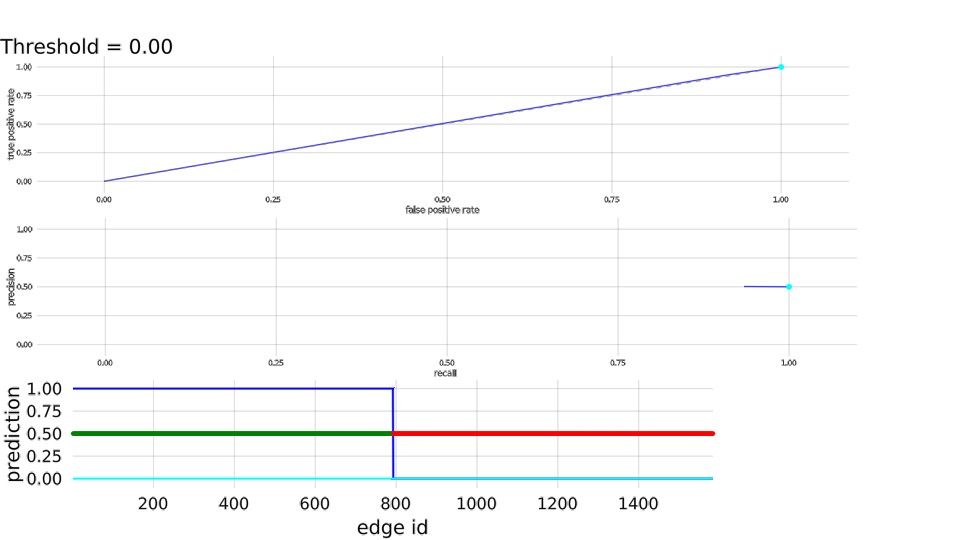

In [27]:
plot_perf(enc = denc, dec = ddec,
    x = features, greal = g,
    test_true_edges = test_true_edges, test_false_edges = test_false_edges)

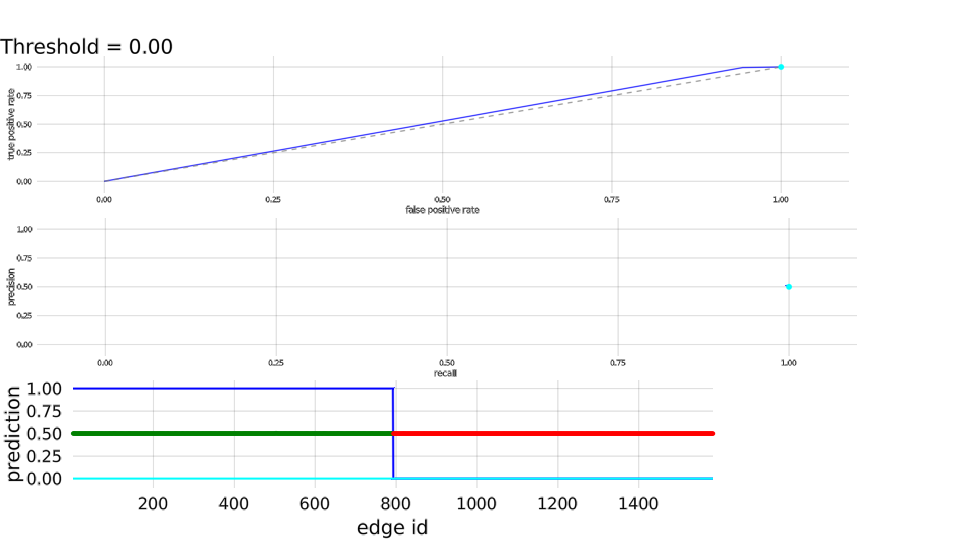

In [28]:
plot_perf(enc = senc, dec = sdec,
    x = features, greal = g,
    test_true_edges = test_true_edges, test_false_edges = test_false_edges)

### Epoch 200

In [29]:
Utils.loadparams!(dparamsvae, dweights200)
Utils.loadparams!(sparamsvae, sweights200)

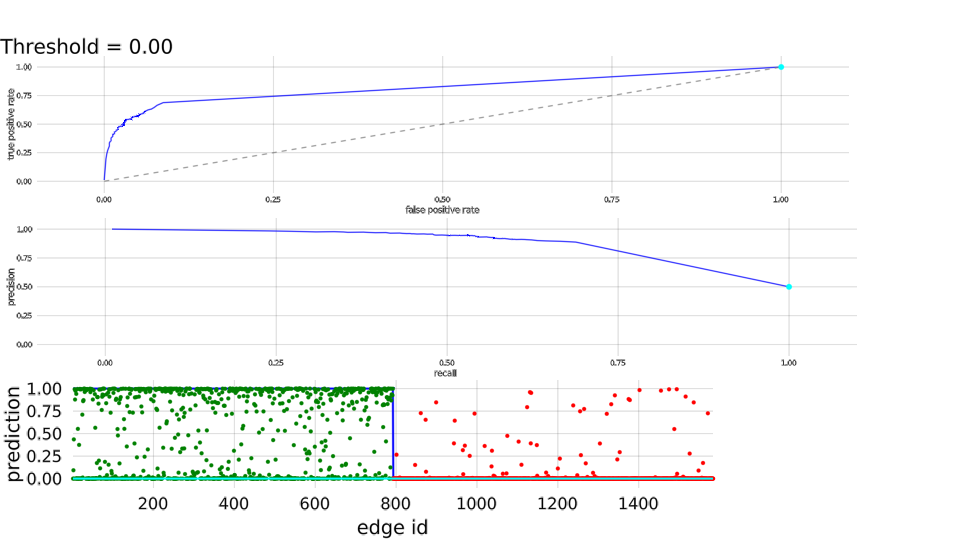

In [32]:
plot_perf(enc = denc, dec = ddec,
    x = features, greal = g,
    test_true_edges = test_true_edges, test_false_edges = test_false_edges)

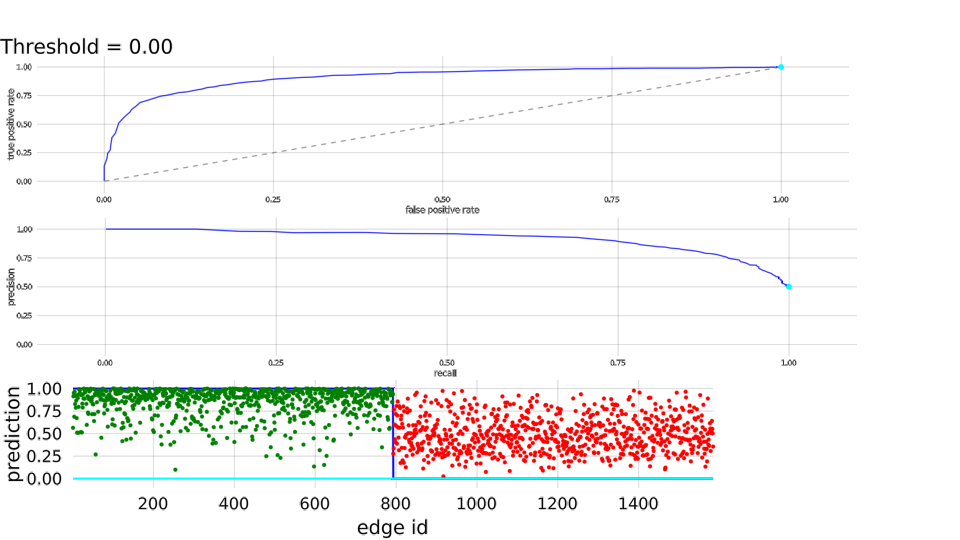

In [31]:
plot_perf(enc = senc, dec = sdec,
    x = features, greal = g,
    test_true_edges = test_true_edges, test_false_edges = test_false_edges)